# Partial Graph Matching

# Import + util + class

In [1]:
#graph_matching.py
GNN_PATH = './GNN/'
import os
if not os.path.exists(GNN_PATH):
    os.makedirs(GNN_PATH)

# Check pytorch version and make sure you use a GPU Kernel
# %%
# ─── Standard library ──────────────────────────────────────────────────────────
import copy
import sys
import pickle
import random
import time
import math
from pathlib import Path
from typing import List, Tuple, Dict, Any
from datetime import datetime

# ─── Third-party libraries ─────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from shapely.affinity import translate
from shapely.geometry import Polygon
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter


from torch_geometric.data import Data, Batch
from torch_geometric.nn import GATv2Conv, GCNConv

from moviepy.editor import ImageSequenceClip
import optuna
import json

#set device as cuda if available to load model and data on gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─── Local application/library imports ────────────────────────────────────────
import pygmtools
pygmtools.BACKEND = 'pytorch'
# %%
# Set Seed for reproducibility
seed = 42

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    os.environ['PYTHONHASHSEED'] = str(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed once at the beginning
set_seed(seed)

# For reproducible DataLoader shuffle
g = torch.Generator()
g.manual_seed(seed)

## Sinkhorn_topk

In [2]:
import torch
import torch.nn as nn
from torch import Tensor

def soft_topk(scores, ks, max_iter=10, tau=1., nrows=None, ncols=None, return_prob=False):
    r"""
    Topk-GM algorithm to suppress matches containing outliers.

    :param scores: :math:`(b\times n_1 \times n_2)` input 3d tensor. :math:`b`: batch size
    :param ks: :math:`(b)` number of matches of each graph pair
    :param max_iter: maximum iterations (default: ``10``)
    :param tau: the hyper parameter :math:`\tau` in Sinkhorn algorithm (default: ``1``)
    :param nrows: :math:`(b)` number of objects in dim1
    :param ncols: :math:`(b)` number of objects in dim2
    :param return_prob: whether to return the soft permutation matrix (default: ``False``)
    :return: :math:`(b\times n_1 \times n_2)` the hard permutation matrix

              if ``return_prob=True``, also return :math:`(b\times n_1 \times n_2)` the computed soft permutation matrix
    """
    dist_mat_list = []
    for idx in range(scores.shape[0]):
        n1 = nrows[idx]
        n2 = ncols[idx]
        anchors = torch.tensor([scores[idx, 0: n1, 0: n2].min(), scores[idx, 0: n1, 0: n2].max()], device=scores.device)
        single_dist_mat = -torch.abs(
            scores[idx, 0: n1, 0: n2].reshape(-1).unsqueeze(-1) - anchors.unsqueeze(0))  # .view(n1, n2, 2)
        dist_mat_list.append(single_dist_mat)

    row_prob = torch.ones(scores.shape[0], scores.shape[1] * scores.shape[2], device=scores.device)
    col_prob = torch.zeros((scores.shape[0], 2), dtype=torch.float, device=scores.device)
    col_prob[:, 1] += ks
    col_prob[:, 0] += nrows * ncols - ks

    sk = Sinkhorn_m(max_iter=max_iter, tau=tau, batched_operation=False)

    output = sk(dist_mat_list, row_prob, col_prob, nrows, ncols)

    top_indices = torch.argsort(output[:, :, 1], descending=True, dim=-1)

    output_s = torch.full(scores.shape, 0, device=scores.device, dtype=scores.dtype)
    for batch in range(output_s.shape[0]):
        output_s[batch, 0: nrows[batch], 0: ncols[batch]] = output[batch, 0: nrows[batch] * ncols[batch], 1].view(nrows[batch], -1)

    x = torch.zeros(scores.shape, device=scores.device)
    x = greedy_perm(x, top_indices, ks)

    if return_prob:
        return x, output_s
    else:
        return x


def greedy_perm(x, top_indices, ks):
    r"""
    Greedy-topk algorithm to select matches with topk confidences.

    :param x: :math:`(b\times n_1 \times n_2)` input 3d tensor. :math:`b`: batch size
    :param top_indices: indices of topk matches
    :param ks: :math:`(b)` number of matches of each graph pair
    :return: :math:`(b\times n_1 \times n_2)` the hard permutation matrix retaining only topk matches
    """
    for b in range(x.shape[0]):
        matched = 0
        cur_idx = 0
        reference_matched_num = round(ks[b].item())
        while matched < reference_matched_num and cur_idx < top_indices.shape[1]:  # torch.ceil(n_points[b])
            idx = top_indices[b][cur_idx]
            row = idx // x.shape[2]  # row = torch.div(idx, x.shape[2], rounding_mode='floor')
            col = idx % x.shape[2]
            if x[b, :, col].sum() < 1 and x[b, row, :].sum() < 1:
                x[b, row, col] = 1
                matched += 1
            cur_idx += 1
    return x


class Sinkhorn_m(nn.Module):
    r"""
    Sinkhorn algorithm with marginal distributions turns the input matrix to satisfy the marginal distributions.

    Sinkhorn algorithm firstly applies an ``exp`` function with temperature :math:`\tau`:

    .. math::
        \mathbf{\Gamma}_{i,j} = \exp \left(\frac{\mathbf{\gamma}_{i,j}}{\tau}\right)

    And then turns the matrix into doubly-stochastic matrix by iterative row- and column-wise normalization:

    .. math::
        \mathbf{\Gamma} &= \text{diag}\left((\mathbf{\Gamma} \mathbf{1} \oslash \mathbf{r})\right)^{-1} \mathbf{\Gamma}\\
        \mathbf{\Gamma} &= \text{diag}\left((\mathbf{\Gamma}^{\top} \mathbf{1} \oslash \mathbf{c})\right)^{-1} \mathbf{\Gamma}

    where :math:`\oslash` means element-wise division, :math:`\mathbf{1}` means a column-vector
    whose elements are all :math:`1`\ s, :math:`\mathbf{r}` and :math:`\mathbf{c}` refers to row and column distribution, respectively.

    :param max_iter: maximum iterations (default: ``10``)
    :param tau: the hyper parameter :math:`\tau` controlling the temperature (default: ``1``)
    :param epsilon: a small number for numerical stability (default: ``1e-4``)
    :param log_forward: apply log-scale computation for better numerical stability (default: ``True``)
    :param batched_operation: apply batched_operation for better efficiency (but may cause issues for back-propagation,
     default: ``False``)

    .. note::
        ``tau`` is an important hyper parameter to be set for Sinkhorn algorithm. ``tau`` controls the distance between
        the predicted doubly-stochastic matrix, and the discrete permutation matrix computed by Hungarian algorithm (see
        :func:`~src.lap_solvers.hungarian.hungarian`). Given a small ``tau``, Sinkhorn performs more closely to
        Hungarian, at the cost of slower convergence speed and reduced numerical stability.

    .. note::
        We recommend setting ``log_forward=True`` because it is more numerically stable. It provides more precise
        gradient in back propagation and helps the model to converge better and faster.

    .. warning::
        If you set ``log_forward=False``, this function behaves a little bit differently: it does not include the
        ``exp`` part.

    .. note::
        Setting ``batched_operation=True`` may be preferred when you are doing inference with this module and do not
        need the gradient.
    """

    def __init__(self, max_iter: int = 10, tau: float = 1., epsilon: float = 1e-4,
                 log_forward: bool = True, batched_operation: bool = False):
        super(Sinkhorn_m, self).__init__()
        self.max_iter = max_iter
        self.tau = tau
        self.epsilon = epsilon
        self.log_forward = log_forward
        if not log_forward:
            print('Warning: Sinkhorn algorithm without log forward is deprecated because log_forward is more stable.')
        self.batched_operation = batched_operation  # batched operation may cause instability in backward computation,
        # but will boost computation.

    def forward(self, s: Tensor, row_prob: Tensor, col_prob: Tensor, nrows: Tensor = None, ncols: Tensor = None,
                dummy_row: bool = False) -> Tensor:
        r"""
        :param s: :math:`(b\times n_1 \times n_2)` input 3d tensor. :math:`b`: batch size
        :param row_prob: marginal distribution for row elements
        :param col_prob: marginal distribution for column elements
        :param nrows: :math:`(b)` number of objects in dim1
        :param ncols: :math:`(b)` number of objects in dim2
        :param dummy_row: whether to add dummy rows (rows whose elements are all 0) to pad the matrix to square matrix.
         default: ``False``
        :return: :math:`(b\times n_1 \times n_2)` the computed doubly-stochastic matrix

        .. note::
            We support batched instances with different number of nodes, therefore ``nrows`` and ``ncols`` are
            required to specify the exact number of objects of each dimension in the batch. If not specified, we assume
            the batched matrices are not padded.

        .. note::
            The original Sinkhorn algorithm only works for square matrices. To handle cases where the graphs to be
            matched have different number of nodes, it is a common practice to add dummy rows to construct a square
            matrix. After the row and column normalizations, the padded rows are discarded.

        .. note::
            We assume row number <= column number. If not, the input matrix will be transposed.
        """
        if self.log_forward:
            return self.forward_log(s, row_prob, col_prob, nrows, ncols, dummy_row)
        else:
            raise NotImplementedError

    def forward_log(self, s, row_prob, col_prob, nrows=None, ncols=None, dummy_row=True):
        """Compute sinkhorn with row/column normalization in the log space."""
        # if len(s.shape) == 2:
        #     s = s.unsqueeze(0)
        #     matrix_input = True
        # elif len(s.shape) == 3:
        #     matrix_input = False
        # else:
        #     raise ValueError('input data shape not understood.')
        matrix_input = False

        batch_size = len(s)  # s.shape[0]

        # operations are performed on log_s
        s = [s[i] / self.tau for i in range(len(s))]

        log_row_prob = torch.log(row_prob).unsqueeze(2)
        log_col_prob = torch.log(col_prob).unsqueeze(1)

        if self.batched_operation:
            log_s = s
            last_log_s = log_s

            for i in range(self.max_iter):
                if i % 2 == 0:
                    log_sum = torch.logsumexp(log_s, 2, keepdim=True)
                    log_s = log_s - log_sum + log_row_prob
                    log_s[torch.isnan(log_s)] = -float('inf')
                    # print(i, torch.max(torch.norm((log_s - last_log_s).view(batch_size, -1), dim=-1)), torch.mean(torch.norm((log_s - last_log_s).view(batch_size, -1), dim=-1)))
                    if torch.max(torch.norm((log_s - last_log_s).view(batch_size, -1), dim=-1)) <= 1e-2:
                        # print(i)
                        break
                    last_log_s = log_s
                else:
                    log_sum = torch.logsumexp(log_s, 1, keepdim=True)
                    log_s = log_s - log_sum + log_col_prob
                    log_s[torch.isnan(log_s)] = -float('inf')

                # ret_log_s[b, row_slice, col_slice] = log_s

            # if i == self.max_iter - 1:
            # print('warning: Sinkhorn is not converged.')

            if matrix_input:
                log_s.squeeze_(0)

            return torch.exp(log_s)
        else:
            # ret_log_s = torch.full((batch_size, s.shape[1], s.shape[2]), -float('inf'), device=s.device, dtype=s.dtype)
            ret_log_s = torch.full((batch_size, nrows.max() * ncols.max(), 2), -float('inf'), device=s[0].device, dtype=s[0].dtype)

            for b in range(batch_size):
                # row_slice = slice(0, nrows[b])
                # col_slice = slice(0, ncols[b])
                log_s = s[b]

                for i in range(self.max_iter):
                    if i % 2 == 0:
                        log_sum = torch.logsumexp(log_s, 1, keepdim=True)
                        log_s = log_s - log_sum + log_row_prob[b, 0: nrows[b] * ncols[b]]
                        log_s[torch.isnan(log_s)] = -float('inf')
                    else:
                        log_sum = torch.logsumexp(log_s, 0, keepdim=True)
                        log_s = log_s - log_sum + log_col_prob[b]
                        log_s[torch.isnan(log_s)] = -float('inf')
                step = self.max_iter
                while torch.any(log_s > 0):
                    if step % 2 == 0:
                        log_sum = torch.logsumexp(log_s, 1, keepdim=True)
                        log_s = log_s - log_sum + log_row_prob[b, 0: nrows[b] * ncols[b]]
                        log_s[torch.isnan(log_s)] = -float('inf')
                    else:
                        log_sum = torch.logsumexp(log_s, 0, keepdim=True)
                        log_s = log_s - log_sum + log_col_prob[b]
                        log_s[torch.isnan(log_s)] = -float('inf')
                    step += 1

                ret_log_s[b, 0: nrows[b] * ncols[b]] = log_s
            # if dummy_row:
            #     if dummy_shape[1] > 0:
            #         ret_log_s = ret_log_s[:, :-dummy_shape[1]]
            #     for b in range(batch_size):
            #         ret_log_s[b, ori_nrows[b]:nrows[b], :ncols[b]] = -float('inf')
            #
            # if transposed:
            #     ret_log_s = ret_log_s.transpose(1, 2)
            if matrix_input:
                ret_log_s.squeeze_(0)

            return torch.exp(ret_log_s)

        # ret_log_s = torch.full((batch_size, s.shape[1], s.shape[2]), -float('inf'), device=s.device, dtype=s.dtype)

        # for b in range(batch_size):
        #    row_slice = slice(0, nrows[b])
        #    col_slice = slice(0, ncols[b])
        #    log_s = s[b, row_slice, col_slice]

    def forward_ori(self, s, nrows=None, ncols=None, dummy_row=False):
        r"""
        Computing sinkhorn with row/column normalization.

        .. warning::
            This function is deprecated because :meth:`~src.lap_solvers.sinkhorn.Sinkhorn.forward_log` is more
            numerically stable.
        """
        if len(s.shape) == 2:
            s = s.unsqueeze(0)
            matrix_input = True
        elif len(s.shape) == 3:
            matrix_input = False
        else:
            raise ValueError('input data shape not understood.')

        batch_size = s.shape[0]

        # s = s.to(dtype=dtype)

        if nrows is None:
            nrows = [s.shape[1] for _ in range(batch_size)]
        if ncols is None:
            ncols = [s.shape[2] for _ in range(batch_size)]

        # tau scaling
        ret_s = torch.zeros_like(s)
        for b, n in enumerate(nrows):
            ret_s[b, 0:n, 0:ncols[b]] = \
                nn.functional.softmax(s[b, 0:n, 0:ncols[b]] / self.tau, dim=-1)
        s = ret_s

        # add dummy elements
        if dummy_row:
            dummy_shape = list(s.shape)
            dummy_shape[1] = s.shape[2] - s.shape[1]
            # s = torch.cat((s, torch.full(dummy_shape, self.epsilon * 10).to(s.device)), dim=1)
            # nrows = nrows + dummy_shape[1] # non in-place
            s = torch.cat((s, torch.full(dummy_shape, 0.).to(s.device)), dim=1)
            ori_nrows = nrows
            nrows = ncols
            for b in range(batch_size):
                s[b, ori_nrows[b]:nrows[b], :ncols[b]] = self.epsilon

        row_norm_ones = torch.zeros(batch_size, s.shape[1], s.shape[1], device=s.device,
                                    dtype=s.dtype)  # size: row x row
        col_norm_ones = torch.zeros(batch_size, s.shape[2], s.shape[2], device=s.device,
                                    dtype=s.dtype)  # size: col x col
        for b in range(batch_size):
            row_slice = slice(0, nrows[b])
            col_slice = slice(0, ncols[b])
            row_norm_ones[b, row_slice, row_slice] = 1
            col_norm_ones[b, col_slice, col_slice] = 1

        s += self.epsilon

        for i in range(self.max_iter):
            if i % 2 == 0:
                # column norm
                # ones = torch.ones(batch_size, s.shape[1], s.shape[1], device=s.device)
                sum = torch.sum(torch.mul(s.unsqueeze(3), col_norm_ones.unsqueeze(1)), dim=2)
            else:
                # row norm
                # ones = torch.ones(batch_size, s.shape[2], s.shape[2], device=s.device)
                sum = torch.sum(torch.mul(row_norm_ones.unsqueeze(3), s.unsqueeze(1)), dim=2)

            tmp = torch.zeros_like(s)
            for b in range(batch_size):
                row_slice = slice(0, nrows[b] if nrows is not None else s.shape[2])
                col_slice = slice(0, ncols[b] if ncols is not None else s.shape[1])
                tmp[b, row_slice, col_slice] = 1 / sum[b, row_slice, col_slice]
            s = s * tmp

        if dummy_row:
            if dummy_shape[1] > 0:
                s = s[:, :-dummy_shape[1]]
            for b in range(batch_size):
                s[b, ori_nrows[b]:nrows[b], :ncols[b]] = 0

        if matrix_input:
            s.squeeze_(0)

        return s

## Utilities

In [3]:
def deserialize_MSD_dataset(data_path, original_path=None, noise_path=None, dimensions_path=None):
    dataset_dir = Path(data_path)

    dimensions = []
    if dimensions_path is not None:
        # Load dimensions
        dimensions_file = dataset_dir / f"{dimensions_path}.pickle"
        if not dimensions_file.exists():
            raise FileNotFoundError(f"Dimensions file not found at {dimensions_file}")
        with open(dimensions_file, 'rb') as f:
            dimensions = pickle.load(f)

    # Clear existing graphs
    original = []
    noise = []

    if original_path is not None:
        original_dir = dataset_dir / original_path
        original_files = sorted(original_dir.glob("*.pt"), key=lambda f: int(f.stem))
        print(f"Loading {len(original_files)} original graphs...")
        for file in tqdm(original_files, desc="Original graphs"):
            with open(str(file), "rb") as f:
                graph = pickle.load(f)
                graph.graph['name'] = file.stem
            original.append(graph)

    if noise_path is not None:
        def extract_numeric_key(file):
            """Extracts (X, Y) from filenames like 'X_Y.pt' for proper numeric sorting."""
            name_parts = file.stem.split("_")
            return int(name_parts[0]), int(name_parts[1])

        noise_dir = dataset_dir / noise_path
        noise_files = sorted(noise_dir.glob("*.pt"), key=extract_numeric_key)
        print(f"Loading {len(noise_files)} noise graphs...")
        for file in tqdm(noise_files, desc="Noise graphs"):
            with open(str(file), "rb") as f:
                graph = pickle.load(f)
                graph.graph['name'] = file.stem
            noise.append(graph)

    return original, noise, dimensions

def deserialize_graph_matching_dataset(path: str, filename: str = "train_dataset.pkl") -> List[Tuple[Data, Data, torch.Tensor]]:
    """
    Deserialize a dataset of (Data1, Data2, PermutationMatrix) tuples from a file.
    """
    full_path = os.path.join(path, filename)

    if not os.path.exists(full_path):
        raise FileNotFoundError(f"File not found: {full_path}")

    with open(full_path, 'rb') as f:
        pairs = pickle.load(f)

    print(f"Loaded {len(pairs)} pairs from {full_path}")
    return pairs

# Create the plot
def plot_losses(train_losses, val_losses, output_path=None):
    epochs = list(range(len(train_losses)))
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=epochs, y=train_losses, label="Training Loss")
    sns.lineplot(x=epochs, y=val_losses, label="Validation Loss")

    # Add labels and title
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.tight_layout()

    if output_path is None:
        plt.show()
    else:
        # Save the plot to the specified path
        plt.savefig(output_path)
        plt.close()

class GraphMatchingDataset(Dataset):
    def __init__(self, pairs):  # lista di (Data, Data, P)
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        return self.pairs[idx]  # data1, data2, P

def collate_pyg_matching(batch):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    data1_list, data2_list, perm_list = zip(*batch)
    
    # Sposta ogni grafo sul device corretto
    data1_list = [d.to(device) for d in data1_list]
    data2_list = [d.to(device) for d in data2_list]
    
    batch1 = Batch.from_data_list(data1_list)
    batch2 = Batch.from_data_list(data2_list)
    
    return batch1, batch2, perm_list

### FUNCTIONS WITH BCE
def bce_permutation_loss(P, P_gt, eps: float = 1e-9):
    """Element-wise Binary Cross Entropy loss between prediction and ground truth."""
    return - (P_gt * torch.log(P + eps) + (1 - P_gt) * torch.log(1 - P + eps)).mean()

def train_epoch_sinkhorn(model, loader, optimizer, writer, epoch, eps: float = 1e-9):
    """
    Trains one epoch of a Sinkhorn-based graph matching model using Binary Cross Entropy (BCE) loss.
    Returns:
        avg_loss (float): average BCE loss per graph.
        all_embeddings (list): collected embeddings from the model.
    """
    model.train()
    total_loss = 0.0
    num_graphs = 0
    all_embeddings = []
    device = next(model.parameters()).device

    for batch1, batch2, perm_list in loader:
        batch1 = batch1.to(device)
        batch2 = batch2.to(device)
        perm_list = [p.to(device) for p in perm_list]

        optimizer.zero_grad()
        batch_idx1 = batch1.batch
        batch_idx2 = batch2.batch
        pred_perm_list, batch_embeddings = model(batch1, batch2, batch_idx1, batch_idx2)

        # accumulo loss per grafo
        batch_loss = 0.0
        for P, P_gt in zip(pred_perm_list, perm_list):
            loss = bce_permutation_loss(P, P_gt, eps)  # assume reduction='mean'
            batch_loss += loss
            total_loss += loss.item()
            num_graphs += 1

        batch_loss = batch_loss / len(pred_perm_list)  # per logging/grad
        batch_loss.backward()
        optimizer.step()

        all_embeddings.extend(batch_embeddings)

    avg_loss = total_loss / num_graphs if num_graphs > 0 else 0.0
    return avg_loss, all_embeddings


def evaluate_sinkhorn(model, loader, eps: float = 1e-9):
    """
    Evaluates a Sinkhorn-based graph matching model using Binary Cross Entropy
    and permutation accuracy.
    Returns:
        avg_acc (float): permutation accuracy over all columns.
        avg_loss (float): average BCE loss per graph.
        all_embeddings (list): collected embeddings from the model.
    """
    model.eval()
    correct = 0
    total_cols = 0
    total_loss = 0.0
    num_graphs = 0
    all_embeddings = []

    device = next(model.parameters()).device
    with torch.no_grad():
        for batch1, batch2, perm_list in loader:
            batch1 = batch1.to(device)
            batch2 = batch2.to(device)
            perm_list = [p.to(device) for p in perm_list]

            batch_idx1 = batch1.batch
            batch_idx2 = batch2.batch
            pred_perm_list, batch_embeddings = model(batch1, batch2, batch_idx1, batch_idx2)

            for P, P_gt in zip(pred_perm_list, perm_list):
                # accuracy
                pred_idx = P.argmax(dim=0)
                target_idx = P_gt.argmax(dim=0)
                correct += (pred_idx == target_idx).sum().item()
                total_cols += P.shape[1]

                # loss per grafo
                loss = bce_permutation_loss(P, P_gt, eps)
                total_loss += loss.item()
                num_graphs += 1

            all_embeddings.extend(batch_embeddings)

    avg_acc = correct / total_cols if total_cols > 0 else 0.0
    avg_loss = total_loss / num_graphs if num_graphs > 0 else 0.0
    return avg_acc, avg_loss, all_embeddings

def train_loop(model, optimizer, train_loader, val_loader, num_epochs, writer,
               best_model_path='checkpoint.pt', final_model_path='final_model.pt',
               patience=10, resume=False):
    best_val_loss = float('inf')
    best_epoch = -1
    patience_counter = 0
    start_epoch = 0

    train_losses = []
    val_losses = []
    val_embeddings_history = []

    # Resume from checkpoint if requested
    if resume and os.path.exists(best_model_path):
        print(f"Loading checkpoint from {best_model_path}")
        checkpoint = torch.load(best_model_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        best_val_loss = checkpoint['best_val_loss']
        start_epoch = checkpoint['epoch'] + 1
        best_epoch = checkpoint['best_epoch']
        print(f"Resumed from epoch {start_epoch}")

    print("Starting training...")

    try:
        for epoch in range(start_epoch, num_epochs):
            # Train
            train_loss, _ = train_epoch_sinkhorn(model, train_loader, optimizer, writer, epoch)
            # Evaluate
            val_acc, val_loss, val_embeddings = evaluate_sinkhorn(model, val_loader)
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_embeddings_history.append(val_embeddings)

            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_epoch = epoch
                patience_counter = 0
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_val_loss': best_val_loss,
                    'best_epoch': best_epoch
                }, best_model_path)
                print(f"[Epoch {epoch}] Saved new best model.")
            else:
                patience_counter += 1

            print(f"Epoch {epoch:03} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch}. Best was {best_epoch}.")
                break

    except KeyboardInterrupt:
        print("Training interrupted manually (Ctrl+C).")

    # Save final model
    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_val_loss': best_val_loss,
    'best_epoch': best_epoch
    }, final_model_path)
    print("Final model saved.")

    return train_losses, val_losses, val_embeddings_history


def plot_two_graphs_with_matching_old(graphs_list, gt_perm, original_graphs, path=None, noise_graphs=None, pred_perm=None,
                                  viz_rooms=True, viz_ws=True,
                                  viz_room_connection=True,
                                  viz_normals=False, viz_room_normals=False,
                                  match_display="all"):
    assert match_display in {"all", "correct", "wrong"}, "match_display must be one of: 'all', 'correct', 'wrong'"
    assert len(graphs_list) == 2, "graphs_list must contain exactly two graphs."
    if noise_graphs is None:
        noise_graphs = original_graphs

    # Extract tensors and original node order
    g1tensor, g2tensor = copy.deepcopy(graphs_list[0]), copy.deepcopy(graphs_list[1])
    # Node names for g1 in original order
    node_names1 = list(g1tensor.node_names)
    # Reconstruct node names for g2 according to its permutation
    orig_names2 = list(g2tensor.node_names)
    perm = g2tensor.permutation.tolist()
    node_names2 = [orig_names2[p] for p in perm]

    # Convert to NetworkX
    g1 = copy.deepcopy(pyg_data_to_nx_digraph(g1tensor, original_graphs))
    g2_original = copy.deepcopy(pyg_data_to_nx_digraph(g2tensor, noise_graphs))
    g2 = g2_original.copy()

    # Translate g2 for side-by-side plot
    max_x_g1 = max(data['center'][0] for _, data in g1.nodes(data=True))
    min_x_g2 = min(data['center'][0] for _, data in g2.nodes(data=True))
    translation_x = (max_x_g1 - min_x_g2) + 10.0
    for _, data in g2.nodes(data=True):
        data['center'][0] += translation_x
        if 'polygon' in data:
            poly = data['polygon']
            if isinstance(poly, Polygon):
                data['polygon'] = translate(poly, xoff=translation_x)
            else:
                data['polygon'] = Polygon([(x + translation_x, y) for x, y in poly])
        if 'limits' in data:
            data['limits'] = [[x + translation_x, y] for x, y in data['limits']]

    fig, ax = plt.subplots(figsize=(16, 10))
    legend_added = set()

    def plot_graph(g, is_g1):
        color_room = 'lightblue' if is_g1 else 'navajowhite'
        color_ws = 'red' if is_g1 else 'purple'
        prefix = "(G1)" if is_g1 else "(G2)"

        if viz_rooms:
            for n, d in g.nodes(data=True):
                if d['type'] == 'room' and 'polygon' in d:
                    poly = Polygon(d['polygon']) if not isinstance(d['polygon'], Polygon) else d['polygon']
                    x, y = poly.exterior.xy
                    ax.fill(x, y, color=color_room, alpha=0.3,
                            label=f"Room polygon {prefix}" if f"room-poly-{prefix}" not in legend_added else "")
                    ax.scatter(d['center'][0], d['center'][1], color='blue', s=80,
                               label=f"Centroid {prefix}" if f"room-pt-{prefix}" not in legend_added else "")
                    legend_added.update({f"room-poly-{prefix}", f"room-pt-{prefix}"})

        if viz_ws:
            for n, d in g.nodes(data=True):
                if d['type'] == 'ws':
                    ax.scatter(d['center'][0], d['center'][1], color=color_ws, s=20,
                               label=f"WS {prefix}" if f"ws-{prefix}" not in legend_added else "")
                    legend_added.add(f"ws-{prefix}")
                    if 'limits' in d:
                        limit1, limit2 = d['limits']
                        ax.plot([limit1[0], limit2[0]], [limit1[1], limit2[1]],
                                color='black', linewidth=1.0,
                                label=f"WS limits {prefix}" if f"limits-{prefix}" not in legend_added else "")
                        legend_added.add(f"limits-{prefix}")

    plot_graph(g1, is_g1=True)
    plot_graph(g2, is_g1=False)

    # Plot matching lines with partial-match and ID presence checks
    if pred_perm is not None:
        for i in range(pred_perm.shape[0]):  # for each row
            # skip if ground truth has no assignment for this node
            if gt_perm[i].sum().item() == 0:
                continue
            row = pred_perm[i]
            # determine if prediction exists
            if row.sum().item() == 0:
                # missing prediction: draw based on ground truth
                j_gt = gt_perm[i].argmax().item()
                # map indices to node IDs
                id1 = node_names1[i]
                if id1 not in g1.nodes:
                    continue
                if j_gt < len(node_names2):
                    id2 = node_names2[j_gt]
                else:
                    continue
                if id2 not in g2.nodes:
                    continue
                pt1 = g1.nodes[id1]['center']
                pt2 = g2.nodes[id2]['center']
                # skip if match_display filters out missing
                if match_display in {"correct", "wrong"}:
                    continue
                color = 'yellow'
                label = None
                if 'missing' not in legend_added:
                    label = 'Missing match'
                    legend_added.add('missing')
                ax.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]],
                        color=color, linestyle='--', alpha=0.6, linewidth=1, label=label)
                continue
            # has prediction: handle correct/wrong
            j = row.argmax().item()
            # map indices to node IDs
            id1 = node_names1[i]
            if id1 not in g1.nodes:
                continue
            if j < len(node_names2):
                id2 = node_names2[j]
            else:
                continue
            if id2 not in g2.nodes:
                continue
            pt1 = g1.nodes[id1]['center']
            pt2 = g2.nodes[id2]['center']
            is_correct = (j < gt_perm.shape[1] and gt_perm[i, j] == 1)
            if match_display == "correct" and not is_correct:
                continue
            if match_display == "wrong" and is_correct:
                continue
            color = 'green' if is_correct else 'red'
            label = None
            if color == 'green' and 'correct' not in legend_added:
                label = 'Correct match'
                legend_added.add('correct')
            elif color == 'red' and 'wrong' not in legend_added:
                label = 'Wrong match'
                legend_added.add('wrong')
            ax.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]],
                    color=color, linestyle='-', alpha=0.6, linewidth=1, label=label)

    ax.set_title("Graph Matching: Green = Correct, Red = Wrong")
    ax.axis("equal")
    ax.legend()
    plt.tight_layout()
    if path is None:
        plt.show()
    else:
        plt.savefig(path)
        plt.close()

def plot_two_graphs_with_matching(graphs_list, gt_perm=None, original_graphs=None, path=None, noise_graphs=None, pred_perm=None,
                                  viz_rooms=True, viz_ws=True,
                                  viz_room_connection=True,
                                  viz_normals=False, viz_room_normals=False,
                                  match_display="all"):
    assert match_display in {"all", "correct", "wrong"}, "match_display must be one of: 'all', 'correct', 'wrong'"
    assert len(graphs_list) == 2, "graphs_list must contain exactly two graphs."
    if noise_graphs is None:
        noise_graphs = original_graphs

    g1tensor, g2tensor = copy.deepcopy(graphs_list[0]), copy.deepcopy(graphs_list[1])
    node_names1 = list(g1tensor.node_names)
    orig_names2 = list(g2tensor.node_names)
    perm = g2tensor.permutation.tolist()
    node_names2 = [orig_names2[p] for p in perm]

    g1 = copy.deepcopy(pyg_data_to_nx_digraph(g1tensor, original_graphs))
    g2_original = copy.deepcopy(pyg_data_to_nx_digraph(g2tensor, noise_graphs))
    g2 = g2_original.copy()

    max_x_g1 = max(data['center'][0] for _, data in g1.nodes(data=True))
    min_x_g2 = min(data['center'][0] for _, data in g2.nodes(data=True))
    translation_x = (max_x_g1 - min_x_g2) + 10.0
    for _, data in g2.nodes(data=True):
        data['center'][0] += translation_x
        if 'polygon' in data:
            poly = data['polygon']
            if isinstance(poly, Polygon):
                data['polygon'] = translate(poly, xoff=translation_x)
            else:
                data['polygon'] = Polygon([(x + translation_x, y) for x, y in poly])
        if 'limits' in data:
            data['limits'] = [[x + translation_x, y] for x, y in data['limits']]

    fig, ax = plt.subplots(figsize=(16, 10))
    legend_added = set()

    def plot_graph(g, is_g1):
        color_room = 'lightblue' if is_g1 else 'navajowhite'
        color_ws = 'red' if is_g1 else 'purple'
        prefix = "(G1)" if is_g1 else "(G2)"
        if viz_rooms:
            for n, d in g.nodes(data=True):
                if d['type'] == 'room' and 'polygon' in d:
                    poly = Polygon(d['polygon']) if not isinstance(d['polygon'], Polygon) else d['polygon']
                    x, y = poly.exterior.xy
                    ax.fill(x, y, color=color_room, alpha=0.3,
                            label=f"Room polygon {prefix}" if f"room-poly-{prefix}" not in legend_added else "")
                    ax.scatter(d['center'][0], d['center'][1], color='blue', s=80,
                               label=f"Centroid {prefix}" if f"room-pt-{prefix}" not in legend_added else "")
                    legend_added.update({f"room-poly-{prefix}", f"room-pt-{prefix}"})
        if viz_ws:
            for n, d in g.nodes(data=True):
                if d['type'] == 'ws':
                    ax.scatter(d['center'][0], d['center'][1], color=color_ws, s=20,
                               label=f"WS {prefix}" if f"ws-{prefix}" not in legend_added else "")
                    legend_added.add(f"ws-{prefix}")
                    if 'limits' in d:
                        limit1, limit2 = d['limits']
                        ax.plot([limit1[0], limit2[0]], [limit1[1], limit2[1]],
                                color='black', linewidth=1.0,
                                label=f"WS limits {prefix}" if f"limits-{prefix}" not in legend_added else "")
                        legend_added.add(f"limits-{prefix}")

    plot_graph(g1, is_g1=True)
    plot_graph(g2, is_g1=False)

    if pred_perm is not None:
        for i in range(pred_perm.shape[0]):
            row = pred_perm[i]
            if row.sum().item() == 0:
                continue  # no prediction for this node
            j = row.argmax().item()
            id1 = node_names1[i]
            if j >= len(node_names2):
                continue
            id2 = node_names2[j]
            if id1 not in g1.nodes or id2 not in g2.nodes:
                continue
            pt1 = g1.nodes[id1]['center']
            pt2 = g2.nodes[id2]['center']

            if gt_perm is not None:
                if gt_perm[i].sum().item() == 0:
                    continue  # no GT match
                is_correct = (j < gt_perm.shape[1] and gt_perm[i, j] == 1)
                if match_display == "correct" and not is_correct:
                    continue
                if match_display == "wrong" and is_correct:
                    continue
                color = 'green' if is_correct else 'red'
                label = 'Correct match' if is_correct else 'Wrong match'
                key = 'correct' if is_correct else 'wrong'
            else:
                # GT is not provided → always plot
                color = 'deepskyblue'
                label = 'Match' if 'predicted' not in legend_added else None
                key = 'predicted'

            if key not in legend_added:
                legend_added.add(key)
            else:
                label = None

            ax.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]],
                    color=color, linestyle='-', alpha=0.6, linewidth=1, label=label)

    ax.set_title("Graph Matching" + (": Green = Correct, Red = Wrong" if gt_perm is not None else ": Predicted matches"))
    ax.axis("equal")
    ax.legend()
    plt.tight_layout()
    if path is None:
        plt.show()
    else:
        plt.savefig(path)
        plt.close()

def normalize_data_pairs(
    pairs: List[Tuple[Data, Data, torch.Tensor]],
    mean: torch.Tensor,
    std: torch.Tensor
) -> List[Tuple[Data, Data, torch.Tensor]]:
    """
    Normalizza per-feature i tensori x in ciascun Data object all'interno delle tuple.

    Args:
        pairs: Lista di tuple (Data1, Data2, P)
        mean: Tensor di media per-feature (shape: [num_features])
        std: Tensor di deviazione standard per-feature (shape: [num_features])

    Returns:
        Lista di tuple con i Data normalizzati.
    """
    normalized_pairs = []
    for data1, data2, P in pairs:
        data1.x = (data1.x - mean) / (std + 1e-8)
        data2.x = (data2.x - mean) / (std + 1e-8)
        normalized_pairs.append((data1, data2, P))
    return normalized_pairs

def compute_mean_std(pairs: List[Tuple[Data, Data, torch.Tensor]]) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Calcola la media e la deviazione standard per-feature dai Data objects nel training set.

    Args:
        pairs: Lista di tuple (Data1, Data2, P) del training set

    Returns:
        Tuple contenente (mean, std) per-feature
    """
    x_list = []
    for data1, data2, _ in pairs:
        x_list.append(data1.x)
        x_list.append(data2.x)
    x_all = torch.cat(x_list, dim=0)
    mean = x_all.mean(dim=0)
    std = x_all.std(dim=0)
    return mean, std


def predict_matching_matrix(model, data1, data2, discrete: bool = True):
    """
    Produces a matching matrix between data1 and data2.
    If discrete=True, returns the permutation matrix.
    Otherwise returns the raw similarity matrix.
    """
    model.eval()
    device = next(model.parameters()).device

    with torch.no_grad():
        data1 = data1.to(device)
        data2 = data2.to(device)
        batch_idx1 = torch.zeros(data1.num_nodes, dtype=torch.long, device=device)
        batch_idx2 = torch.zeros(data2.num_nodes, dtype=torch.long, device=device)

        sim_matrix_list, _ = model(data1, data2, batch_idx1, batch_idx2, inference=discrete)
        sim = sim_matrix_list[0].unsqueeze(0)  # [1, N1, N2]

        n1 = torch.tensor([sim.shape[1]], dtype=torch.int32, device=device)
        n2 = torch.tensor([sim.shape[2]], dtype=torch.int32, device=device)
    
        return sim.squeeze(0)

node_type_mapping = {"room": [1, 0], "ws": [0, 1]}

def pyg_data_to_nx_digraph(data: Data, graph_list: List[nx.DiGraph]) -> nx.DiGraph:
    """
    Convert a PyTorch Geometric Data object back to a NetworkX DiGraph,
    restoring original node IDs using data.node_names and data.permutation,
    matching with the graph in graph_list that has the same name.
    """
    assert hasattr(data, 'node_names'), \
        "Data object must contain 'node_names' to restore original node IDs."
    assert hasattr(data, 'permutation'), \
        "Data object must contain 'permutation' to reorder nodes."
    assert hasattr(data, 'name'), \
        "Data object must contain 'name' to match with graph_list."

    matching_graph = next((g for g in graph_list if g.graph.get('name') == data.name), None)
    if matching_graph is None:
        raise ValueError(f"No graph with name {data.name} found in graph_list.")

    orig_names = data.node_names
    perm = data.permutation.tolist()
    node_ids = [orig_names[idx] for idx in perm]

    G = nx.DiGraph()
    for node_id in node_ids:
        if node_id in matching_graph.nodes:
            G.add_node(node_id, **matching_graph.nodes[node_id])

    for u_idx, v_idx in data.edge_index.t().tolist():
        u = node_ids[u_idx]
        v = node_ids[v_idx]
        if matching_graph.has_edge(u, v):
            G.add_edge(u, v, **matching_graph.edges[u, v])

    G.graph['name'] = data.name
    return G

def nx_to_pyg_data_preserve_order(graph: nx.DiGraph) -> Data:
    """
    Convert a NetworkX DiGraph to a PyTorch Geometric Data object,
    preserving node insertion order, storing 'node_names' and an identity 'permutation'.
    """
    node_ids = list(graph.nodes())
    id_map = {nid: i for i, nid in enumerate(node_ids)}

    x = torch.stack([
        torch.tensor(
            node_type_mapping[graph.nodes[n]['type']] +
            graph.nodes[n]['center'] +
            graph.nodes[n]['normal'] +
            [graph.nodes[n].get('length', -1)],
            dtype=torch.float32
        )
        for n in node_ids
    ])

    edge_index = torch.tensor(
        [[id_map[u], id_map[v]] for u, v in graph.edges()],
        dtype=torch.long
    ).t().contiguous() if graph.edges else torch.empty((2, 0), dtype=torch.long)

    data = Data(x=x, edge_index=edge_index)
    data.name = graph.graph.get('name')
    data.node_names = node_ids
    data.permutation = torch.arange(len(node_ids), dtype=torch.long)
    return data


def normalize_graph(g1, g2, mean, std):
    g1.x = (g1.x - mean) / (std + 1e-8)
    g2.x = (g2.x - mean) / (std + 1e-8)

    return g1, g2

###     PARTIAL GRAPH MATCHING MODEL
class MatchingModel_GATv2SinkhornTopK(nn.Module):
    def __init__(
        self,
        in_dim: int,
        hidden_dim: int,
        out_dim: int,
        sinkhorn_max_iter: int = 15,
        sinkhorn_tau: float = 0.1,
        attention_dropout: float = 0.1,
        dropout_emb: float = 0.1,
        temperature: float = 1.0
    ):
        super().__init__()
        self.gnn = nn.ModuleList([
            GATv2Conv(in_dim, hidden_dim, dropout=attention_dropout),
            GATv2Conv(hidden_dim, out_dim, dropout=attention_dropout),
        ])
        self.dropout = nn.Dropout(p=dropout_emb)
        # # bilinear weight matrix A per affinity
        # std = 1.0 / math.sqrt(out_dim)
        # self.A = nn.Parameter(torch.randn(out_dim, out_dim) * std)
        # # temperature per affinities
        # self.temperature = temperature
        # InstanceNorm per-sample
        self.inst_norm = nn.InstanceNorm2d(1, affine=True)
        # Sinkhorn hyperparams
        self.sinkhorn_max_iter = sinkhorn_max_iter
        self.sinkhorn_tau = sinkhorn_tau

    def encode(self, x, edge_index):
        for i, conv in enumerate(self.gnn):
            x = conv(x, edge_index)
            if i < len(self.gnn) - 1:
                x = F.relu(x)
                x = self.dropout(x)
        return x

    def forward(self, batch1, batch2, batch_idx1=None, batch_idx2=None, inference=False):
        device = next(self.parameters()).device

        x1, edge1 = batch1.x.to(device), batch1.edge_index.to(device)
        x2, edge2 = batch2.x.to(device), batch2.edge_index.to(device)

        batch_idx1 = batch1.batch.to(device) if batch_idx1 is None else batch_idx1.to(device)
        batch_idx2 = batch2.batch.to(device) if batch_idx2 is None else batch_idx2.to(device)

        h1 = self.encode(x1, edge1)
        h2 = self.encode(x2, edge2)

        B = batch_idx1.max().item() + 1
        perm_pred_list = []
        all_embeddings = []

        for b in range(B):
            h1_b = h1[batch_idx1 == b]   # [n1, d]
            h2_b = h2[batch_idx2 == b]   # [n2, d]
            N1, N2 = h1_b.size(0), h2_b.size(0)

            # # ---- bilinear affinity ----
            # # scores_{ij} = (h1_b @ A @ h2_b.T) / temperature
            # scores = (h1_b @ self.A) @ h2_b.T
            # M = torch.exp(scores / self.temperature)  # [n1, n2]
            # # normalize and sinkhorn
            # M_batched = M.unsqueeze(0).unsqueeze(1)  # [1,1,n1,n2]
            # M_normed = self.inst_norm(M_batched).squeeze(1)  # [1,n1,n2] -> [n1,n2]

            # affinity matrix + normalization + sinkhorn
            sim = torch.matmul(h1_b, h2_b.T) # [n1, n2]
            sim_batched = sim.unsqueeze(0).unsqueeze(1) # [1,1,n1,n2]
            sim_normed = self.inst_norm(sim_batched).squeeze(1) # [1,n1,n2] -> [n1,n2]

            n1_t = torch.tensor([N1], dtype=torch.int32, device=device)
            n2_t = torch.tensor([N2], dtype=torch.int32, device=device)
            S = pygmtools.sinkhorn(sim_normed, n1=n1_t, n2=n2_t, max_iter=self.sinkhorn_max_iter, tau=self.sinkhorn_tau)
            
            ks_gt = torch.tensor([N2], dtype=torch.long, device=device)
            
            hard_S, soft_S = soft_topk(
                S, ks_gt,
                max_iter=self.sinkhorn_max_iter,
                tau=self.sinkhorn_tau,
                nrows=n1_t, ncols=n2_t,
                return_prob=True
            )

            if inference:
                perm_pred_list.append(hard_S[0])
            else:
                perm_pred_list.append(soft_S[0])

            all_embeddings.append((h1_b, h2_b))

        return perm_pred_list, all_embeddings

## Partial Graph Matching Class


In [4]:
# Iperparametri
in_dim = 7
hidden_dim = 64
out_dim = 32
num_epochs = 200
learning_rate = 1e-3
batch_size = 16
weight_decay = 5e-5
patience = 30

class PartialGraphMatching:
    def __init__(
        self,
        model_class,
        data_paths,
        model_save_path,
        in_dim,
        hidden_dim,
        out_dim,
        batch_size,
        learning_rate,
        weight_decay,
        num_epochs,
        patience,
        device,
        seed=42
    ):
        self.device = device
        self.batch_size = batch_size
        self.model_save_path = model_save_path
        self.best_model_path = os.path.join(model_save_path, 'best_val_model.pt')
        self.final_model_path = os.path.join(model_save_path, 'final_model.pt')
        self.seed = seed

        # Model & optimizer
        self.model = model_class(in_dim=in_dim, hidden_dim=hidden_dim, out_dim=out_dim).to(device)
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)

        # Load data
        self._load_data(data_paths)

        # Training params
        self.num_epochs = num_epochs
        self.patience = patience

    def _load_data(self, paths):
        self.original_graphs = deserialize_graph_matching_dataset(paths["equal"], "original.pkl")
        self.noise_graphs = deserialize_graph_matching_dataset(paths["partial"], "noise.pkl")
        self.train_list = deserialize_graph_matching_dataset(paths["partial"], "train_dataset.pkl")
        self.val_list = deserialize_graph_matching_dataset(paths["partial"], "valid_dataset.pkl")
        self.test_list = deserialize_graph_matching_dataset(paths["partial"], "test_dataset.pkl")

        self.train_dataset = GraphMatchingDataset(self.train_list)
        self.val_dataset = GraphMatchingDataset(self.val_list)
        self.test_dataset = GraphMatchingDataset(self.test_list)

        g = torch.Generator().manual_seed(self.seed)

        self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, collate_fn=collate_pyg_matching, generator=g)
        self.val_loader = DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, collate_fn=collate_pyg_matching)
        self.test_loader = DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, collate_fn=collate_pyg_matching)

        mean, std = compute_mean_std(self.train_dataset)
        self.mean = mean
        self.std = std

    def train(self):
        print(self.model)
        print(f"Number of parameters: {sum(p.numel() for p in self.model.parameters())}")

        self.train_losses, self.val_losses, self.val_embeddings_history = train_loop(
            model=self.model,
            optimizer=self.optimizer,
            train_loader=self.train_loader,
            val_loader=self.val_loader,
            num_epochs=self.num_epochs,
            writer=self.writer,
            best_model_path=self.best_model_path,
            final_model_path=self.final_model_path,
            patience=self.patience,
            resume=False
        )

        plot_losses(self.train_losses, self.val_losses, os.path.join(self.model_save_path, 'losses.png'))

    def load_best_model(self):
        checkpoint = torch.load(self.best_model_path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.model.to(self.device)

    def evaluate(self):
        test_acc, test_loss, test_embeddings = evaluate_sinkhorn(self.model, self.test_loader)
        print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")
        return test_acc, test_loss

    def inference(self, index_to_plot=3, discrete=True):
        inference_times = []
        correct = 0
        total_cols = 0

        for i, (g1_out, g2_perm, gt_perm) in enumerate(self.test_list):
            start_time = time.time()
            result = predict_matching_matrix(self.model, g1_out, g2_perm, discrete=discrete)
            end_time = time.time()
            inference_times.append(end_time - start_time)

            errors = (result != gt_perm.to(result.device)).sum().item()
            if errors > 0:
                print(f"Graph {i}: Errors found: {errors}")

            pred_idx = result.argmax(dim=0)
            target_idx = gt_perm.argmax(dim=0)
            correct += (pred_idx == target_idx).sum().item()
            total_cols += result.shape[1]

        accuracy = correct / total_cols if total_cols > 0 else 0.0
        print(f"Test Accuracy (after Hungarian): {accuracy:.4f}")
        print(f"Inference time: {np.mean(inference_times):.6f} ± {np.std(inference_times):.6f} seconds")

        # Visualizza un esempio
        g1_out, g2_perm, gt_perm = self.test_list[index_to_plot]
        print(g1_out.name)
        result = predict_matching_matrix(self.model, g1_out, g2_perm, discrete=discrete)
        plot_two_graphs_with_matching(
            [g1_out, g2_perm],
            gt_perm=gt_perm,
            pred_perm=result,
            original_graphs=self.original_graphs,
            noise_graphs=self.noise_graphs,
            viz_rooms=True,
            viz_ws=True,
            match_display="wrong",
        )

    def infer_matching(self, g1, g2, discrete=True):
        """
        Effettua il matching tra due grafi normalizzati.

        Args:
            model: modello addestrato
            g1, g2: torch_geometric.data.Data (singola coppia di grafi)
            mean, std: dizionari di normalizzazione {key: tensor}
            discrete (bool): se True ritorna la matrice hard, altrimenti quella soft

        Returns:
            matching_matrix: torch.Tensor [N1, N2]
        """
        # Preprocessing
        original = [g1]
        noise = [g2]
        g1_pyg = nx_to_pyg_data_preserve_order(g1)
        g2_pyg = nx_to_pyg_data_preserve_order(g2)

        # Normalizzazione dei due grafi
        g1_pyg, g2_pyg = normalize_graph(g1_pyg, g2_pyg, self.mean, self.std)

        # Calcolo matrice di matching (soft o hard)
        matching_matrix = predict_matching_matrix(self.model, g1_pyg, g2_pyg, discrete=discrete)

        # Visualizza un esempio
        plot_two_graphs_with_matching(
            [g1_pyg, g2_pyg],
            pred_perm=matching_matrix,
            original_graphs=original,
            noise_graphs=noise,
            viz_rooms=True,
            viz_ws=True,
            match_display="all"
        )

        return matching_matrix


# Unit test

In [5]:
paths = {
    "equal": os.path.join(GNN_PATH, "preprocessed", "graph_matching", "equal"),
    "partial": os.path.join(GNN_PATH, "preprocessed", "partial_graph_matching", "room_dropout_noise")
}
exp = PartialGraphMatching(
    model_class=MatchingModel_GATv2SinkhornTopK,
    data_paths=paths,
    model_save_path=os.path.join(GNN_PATH, 'models', "partial_graph_matching", "room_dropout_noise"),
    in_dim=in_dim,
    hidden_dim=hidden_dim,
    out_dim=out_dim,
    batch_size=batch_size,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    num_epochs=num_epochs,
    patience=patience,
    device=device
)

Loaded 4895 pairs from ./GNN/preprocessed/graph_matching/equal/original.pkl
Loaded 4895 pairs from ./GNN/preprocessed/partial_graph_matching/room_dropout_noise/noise.pkl
Loaded 3426 pairs from ./GNN/preprocessed/partial_graph_matching/room_dropout_noise/train_dataset.pkl
Loaded 734 pairs from ./GNN/preprocessed/partial_graph_matching/room_dropout_noise/valid_dataset.pkl
Loaded 735 pairs from ./GNN/preprocessed/partial_graph_matching/room_dropout_noise/test_dataset.pkl


In [6]:
# exp.train()

exp.load_best_model()
# exp.evaluate()
exp.inference()

Graph 0: Errors found: 38
Graph 1: Errors found: 8
Graph 2: Errors found: 10
Graph 3: Errors found: 26
Graph 4: Errors found: 46
Graph 5: Errors found: 26
Graph 6: Errors found: 14
Graph 7: Errors found: 24
Graph 8: Errors found: 10
Graph 9: Errors found: 28
Graph 10: Errors found: 16
Graph 11: Errors found: 76
Graph 12: Errors found: 30
Graph 13: Errors found: 48
Graph 14: Errors found: 22
Graph 15: Errors found: 10
Graph 16: Errors found: 16
Graph 17: Errors found: 30
Graph 18: Errors found: 14
Graph 19: Errors found: 30
Graph 20: Errors found: 28
Graph 21: Errors found: 54
Graph 22: Errors found: 36
Graph 23: Errors found: 34
Graph 24: Errors found: 32
Graph 25: Errors found: 24
Graph 26: Errors found: 40
Graph 27: Errors found: 36
Graph 28: Errors found: 20
Graph 29: Errors found: 40
Graph 31: Errors found: 28
Graph 32: Errors found: 16
Graph 33: Errors found: 44
Graph 34: Errors found: 46
Graph 35: Errors found: 86
Graph 36: Errors found: 12
Graph 37: Errors found: 26
Graph 38: Er

KeyboardInterrupt: 

Loading 4895 original graphs...


Original graphs: 100%|██████████| 4895/4895 [00:17<00:00, 274.13it/s]


Loading 4895 original graphs...


Original graphs: 100%|██████████| 4895/4895 [00:24<00:00, 196.32it/s]


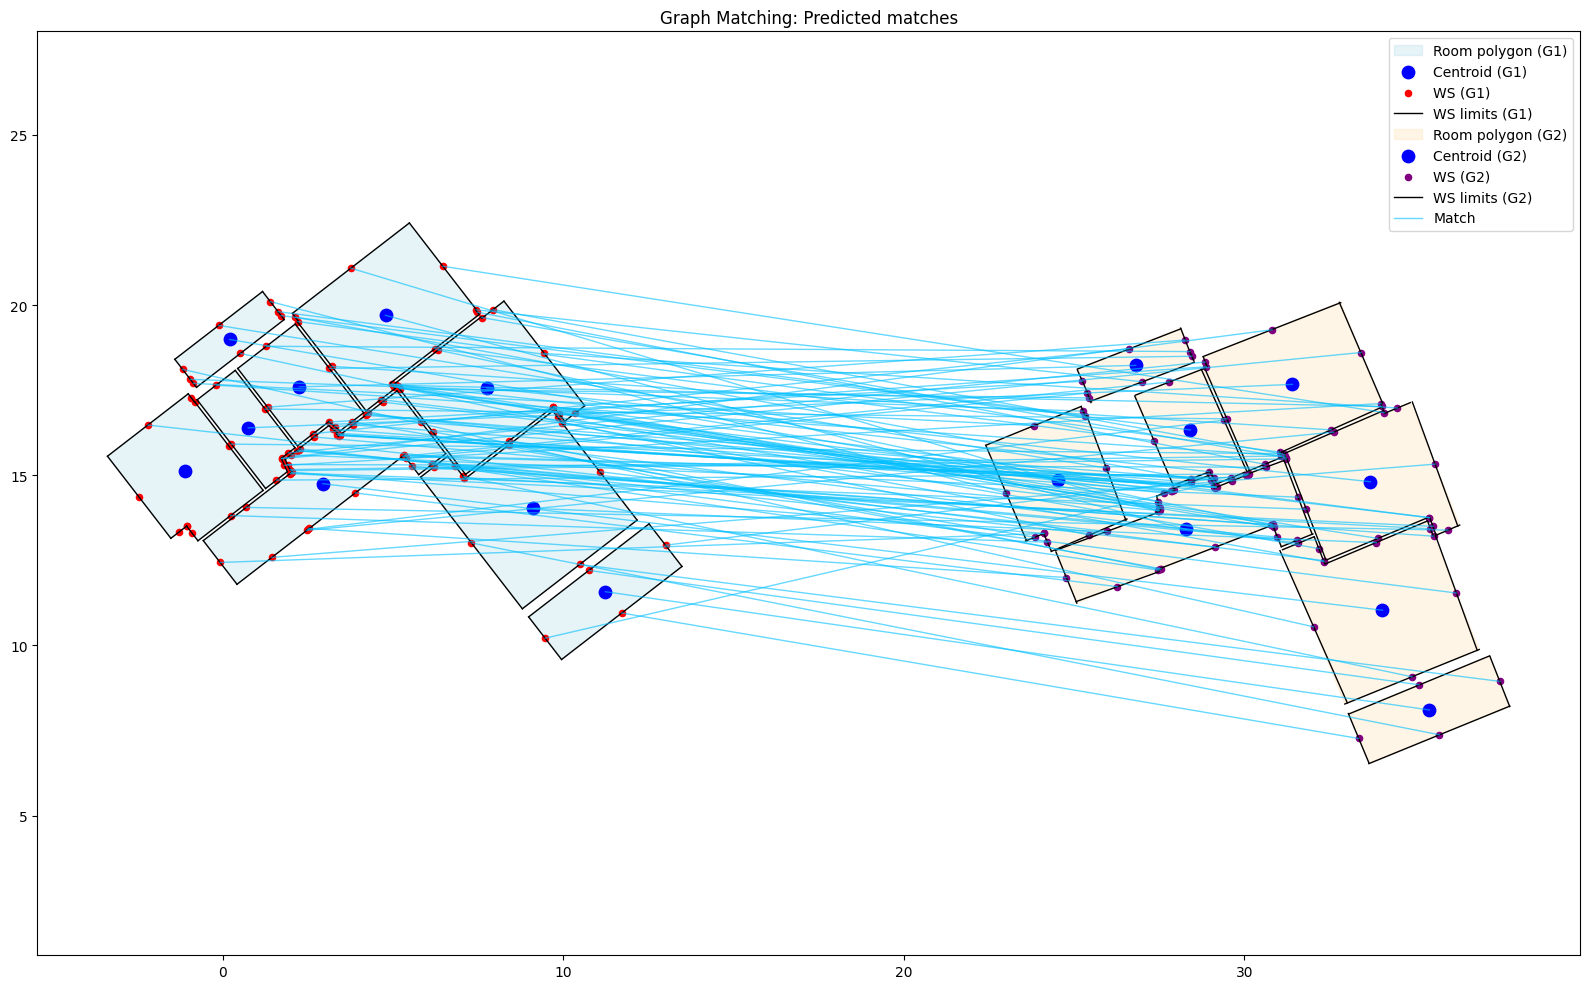

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [7]:
# graph matching-equal path
gm_path = os.path.join(GNN_PATH, "raw", "graph_matching")
original_graphs, _, _ = deserialize_MSD_dataset(data_path=gm_path, original_path="equal")
# graph matching path
gm_path = os.path.join(GNN_PATH, "raw", "partial_graph_matching")
noise_graphs, _, _ = deserialize_MSD_dataset(data_path=gm_path, original_path="room_dropout_noise")

matching = exp.infer_matching(original_graphs[1310], noise_graphs[1310])
print(matching)